In [1]:
import polars as pl
import polars.selectors as cs
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from alibi.explainers import ALE, plot_ale
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

In [2]:
df = pl.read_csv("../data/train.csv").drop("id")
df.head()

Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
str,f64,f64,f64,str,str,f64,f64,str,str,f64,str,f64,f64,str,str,str
"""Male""",24.443011,1.699998,81.66995,"""yes""","""yes""",2.0,2.983297,"""Sometimes""","""no""",2.763573,"""no""",0.0,0.976473,"""Sometimes""","""Public_Transpo…","""Overweight_Lev…"
"""Female""",18.0,1.56,57.0,"""yes""","""yes""",2.0,3.0,"""Frequently""","""no""",2.0,"""no""",1.0,1.0,"""no""","""Automobile""","""Normal_Weight"""
"""Female""",18.0,1.71146,50.165754,"""yes""","""yes""",1.880534,1.411685,"""Sometimes""","""no""",1.910378,"""no""",0.866045,1.673584,"""no""","""Public_Transpo…","""Insufficient_W…"
"""Female""",20.952737,1.71073,131.274851,"""yes""","""yes""",3.0,3.0,"""Sometimes""","""no""",1.674061,"""no""",1.467863,0.780199,"""Sometimes""","""Public_Transpo…","""Obesity_Type_I…"
"""Male""",31.641081,1.914186,93.798055,"""yes""","""yes""",2.679664,1.971472,"""Sometimes""","""no""",1.979848,"""no""",1.967973,0.931721,"""Sometimes""","""Public_Transpo…","""Overweight_Lev…"


In [3]:
df = df.select(
    # cs.string().cast(pl.Categorical),
    # ~cs.string()
    pl.col("Gender").map_batches(LabelEncoder().fit_transform).alias("Gender"),
    pl.col("CAEC").map_batches(LabelEncoder().fit_transform).alias("CAEC"),
    pl.col("SMOKE").map_batches(LabelEncoder().fit_transform).alias("SMOKE"),
    pl.col("SCC").map_batches(LabelEncoder().fit_transform).alias("SCC"),
    pl.col("MTRANS").map_batches(LabelEncoder().fit_transform).alias("MTRANS"),
    pl.col("CALC").map_batches(LabelEncoder().fit_transform).alias("CALC"),
    pl.col("NObeyesdad").map_batches(LabelEncoder().fit_transform).alias("NObeyesdad"),
    pl.col("family_history_with_overweight").map_batches(LabelEncoder().fit_transform).alias("family_history_with_overweight"),
    cs.float()
)
df.head()


Gender,CAEC,SMOKE,SCC,MTRANS,CALC,NObeyesdad,family_history_with_overweight,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64
1,2,0,0,3,1,6,1,24.443011,1.699998,81.66995,2.0,2.983297,2.763573,0.0,0.976473
0,1,0,0,0,2,1,1,18.0,1.56,57.0,2.0,3.0,2.0,1.0,1.0
0,2,0,0,3,2,0,1,18.0,1.71146,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584
0,2,0,0,3,1,4,1,20.952737,1.71073,131.274851,3.0,3.0,1.674061,1.467863,0.780199
1,2,0,0,3,1,6,1,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721


In [4]:
y_col = "NObeyesdad"
y = df[y_col]

X = df.drop(y_col)

In [6]:
# gb = HistGradientBoostingClassifier(categorical_features=["Gender", "SMOKE", "FAVC", "CAEC", "SCC", "CALC", "MTRANS", "family_history_with_overweight"])
gb = HistGradientBoostingClassifier()
gb_y_pred = cross_val_predict(gb, X, y.to_list(), cv=10, n_jobs=10)
print(classification_report(y, gb_y_pred))
gb.fit(X, y)


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2523
           1       0.87      0.88      0.87      3082
           2       0.90      0.88      0.89      2910
           3       0.97      0.97      0.97      3248
           4       1.00      1.00      1.00      4046
           5       0.80      0.76      0.78      2427
           6       0.80      0.81      0.80      2522

    accuracy                           0.90     20758
   macro avg       0.89      0.89      0.89     20758
weighted avg       0.90      0.90      0.90     20758



HistGradientBoostingClassifier()

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_y_pred = cross_val_predict(rf, X, y.to_list(), cv=10, n_jobs=10)
print(classification_report(y, rf_y_pred))
rf.fit(X, y)

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2523
           1       0.84      0.88      0.86      3082
           2       0.89      0.88      0.88      2910
           3       0.97      0.97      0.97      3248
           4       1.00      1.00      1.00      4046
           5       0.78      0.72      0.75      2427
           6       0.78      0.78      0.78      2522

    accuracy                           0.89     20758
   macro avg       0.88      0.88      0.88     20758
weighted avg       0.89      0.89      0.89     20758



RandomForestClassifier()

In [8]:
proba_ale_gb = ALE(gb.predict_proba, feature_names=X.columns, target_names=df[y_col].unique().to_list())
proba_exp_gb = proba_ale_gb.explain(X.to_numpy())

proba_ale_rf = ALE(rf.predict_proba, feature_names=X.columns, target_names=df[y_col].unique().to_list())
proba_exp_rf = proba_ale_rf.explain(X.to_numpy())

/home/dondon/.local/share/hatch/env/virtual/obesity-risk/g1Q1rl5i/obesity-risk/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/dondon/.local/share/hatch/env/virtual/obesity-risk/g1Q1rl5i/obesity-risk/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/dondon/.local/share/hatch/env/virtual/obesity-risk/g1Q1rl5i/obesity-risk/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/dondon/.local/share/hatch/env/virtual/obesity-risk/g1Q1rl5i/obesity-risk/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was

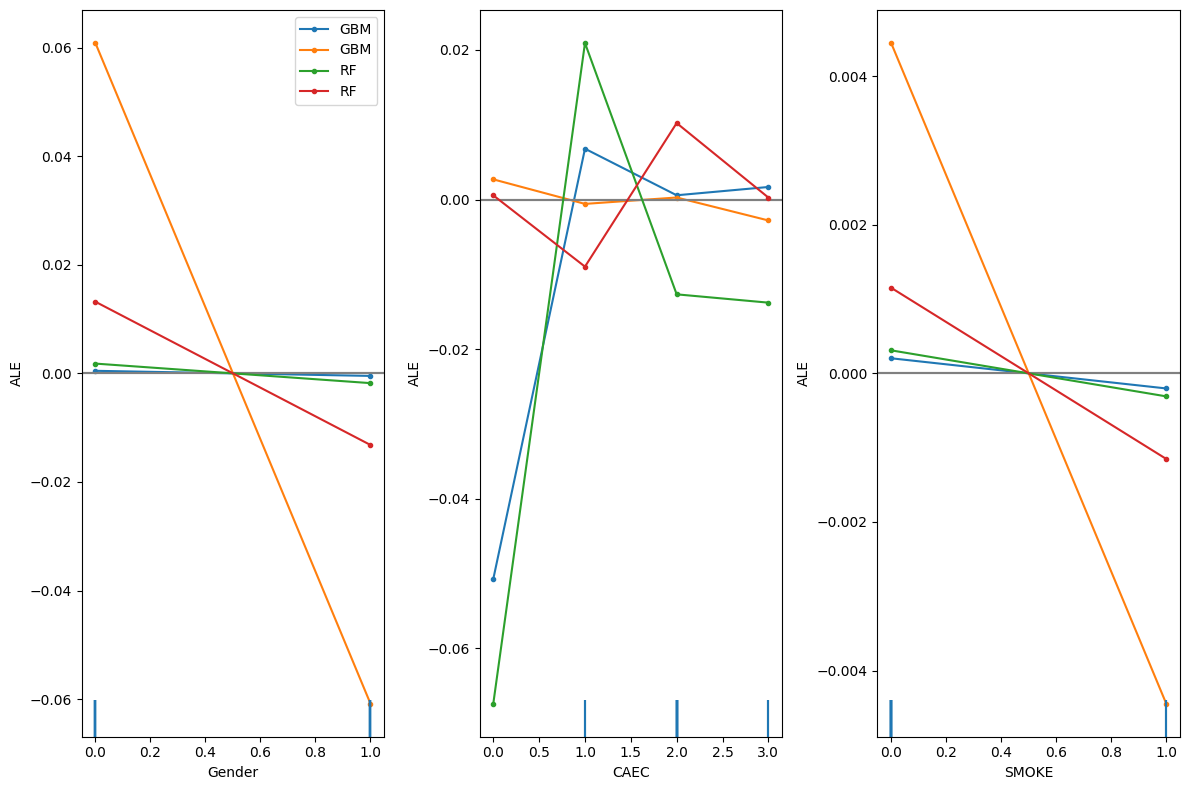

In [9]:
import matplotlib.pyplot as plt
features = [0, 1, 2]
targets = [0, 2]
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
plot_ale(proba_exp_gb, features=features, targets=targets, ax=ax, line_kw={"label": "GBM"});
plot_ale(proba_exp_rf, features=features, targets=targets, ax=ax, line_kw={"label": "RF"});

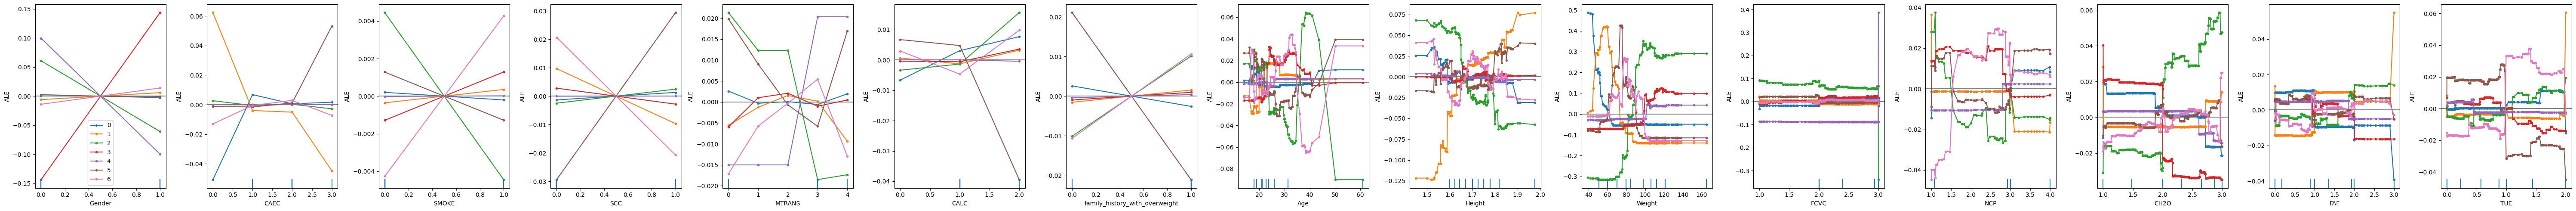

In [10]:
n_feats = len(X.columns)
fig, ax = plt.subplots(1, n_feats, figsize=(4 * n_feats, 5))
plot_ale(proba_exp_gb, ax=ax);